In [1]:
import gzip
from datetime import datetime
from collections import defaultdict
import math
import scipy
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
import json
import time
import requests
import re
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def readCSV(path):
    #user,id,start_date,end_date,score,num_episodes_watched,status
    #status encoding: watching = 0, completed = 1, on_hold = 2, dropped = 3, plan_to_watch = 4
    f = open(path, 'r')
    
    for l in f:
        user,anime_id,start_date,end_date,score,num_episodes_watched,status = l.strip().split(',')
        anime_id=int(anime_id)
        score=int(score)
        num_episodes_watched=int(num_episodes_watched)
        status = int(status)
        yield user,anime_id,start_date,end_date,score,num_episodes_watched,status

In [4]:
#Get API KEY in case we need it
file = open("../data/mal_client_id.txt", 'r')
clientID = file.read()
file.close()

In [5]:
completed_with_date = []
for i in readCSV('../data/user_animelist_details.txt'):
    if (i[6] == 1 and i[3] != "" and i[4] != 0):
        completed_with_date.append(i)

In [13]:
#scores per anime
scoresPerAnime = defaultdict(list)
for i in completed_with_date:
    scoresPerAnime[i[1]].append(i[4])

In [112]:
#earliest review date
smallest = datetime.strptime(completed_with_date[0][3],'%Y-%m-%d')
foundingDate = datetime.strptime('1988-01-01','%Y-%m-%d') #akira air date

for i in completed_with_date:
    #some date data is in a different format, can tell by length
    if(len(i[3]) == 10):
        tempDate = datetime.strptime(i[3],'%Y-%m-%d')
    elif (len(i[3]) == 4):
        tempDate = datetime.strptime(i[3],'%Y')
    elif (len(i[3]) == 7):
        tempDate = datetime.strptime(i[3],'%Y-%m')
    else:
        #we don't know the date so we toss it
        continue

    #some date data has been entered before MAL was created. We will throw this out
    #by checking against the foundingDate
    if( tempDate <= smallest and tempDate >= foundingDate):
        smallest = tempDate
print(smallest)

1988-01-01 00:00:00


In [137]:
#ratings as a function of date graph
#first we need date bins, done by year, 24 years since 2004
maxDate = 2022
minDate = 1988
yearbins = [[] for j in range(maxDate - minDate + 1)]

#iterate through the data, put score in the correct bin
for i in completed_with_date:
    #known formats all have year as first 4 letters, we just extract that and cast to int to get correct bin
    #then add the score
    if(len(i[3]) == 10 or len(i[3]) == 7 or len(i[3]) == 4 ):
        #we do a quick check to make sure it is below our maxDate and above our maxDate, and then add it to our bing
        if(int(i[3][:4]) >= minDate and int(i[3][:4]) <= maxDate):
            yearbins[int(i[3][:4]) - minDate].append(i[4])
        
    #we don't know the date so we toss it
    else:
        continue


In [141]:
#now we get the year averages
yearavgs = []
for yearbin in yearbins:
    yearavgs.append(sum(yearbin)/len(yearbin))

In [145]:
#labels for the years
years = [1988 + i for i in range(maxDate-minDate+1)]

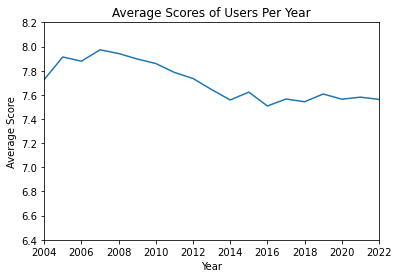

In [374]:
plt.plot(years,yearavgs)
plt.axis([2004, 2022, 6.4, 8.2])

plt.xlabel('Year')
plt.ylabel('Average Score')
plt.title('Average Scores of Users Per Year')
plt.show()

In [7]:
#now let's look at the how the age of anime affects their scores
file = open("../data/anime_list_details.json", 'r')
animelist = json.loads(file.read())

In [8]:
animelistdict = dict()
for i in animelist:
    if('title' in i and 'mean' in i and 'num_list_users' in i and 'start_date' in i):
        animelistdict[i['id']]= {
            'title': i['title'],
            'num_list_users': i['num_list_users'],
            'start_date': i['start_date'],
            'mean': i['mean']
        }

In [9]:
animelistdict2 = dict()
for i in animelist:
    if('broadcast' in i):
        animelistdict2[i['id']]= {
            'title': i['title'],
            'num_list_users': i['num_list_users'],
            'start_date': i['start_date'],
            'broadcast': i['broadcast'],
        }

In [10]:
animelistdict3 = dict()
for i in animelist:
    if('start_season' in i):
        animelistdict3[i['id']]= {
            'title': i['title'],
            'num_list_users': i['num_list_users'],
            'start_date': i['start_date'],
            'start_season': i['start_season'],
        }

In [253]:
#now let's bin the anime and their mean scores multiplied by the number of user ratings using same bins as the users
#ratings as a function of date graph
#first we need date bins, done by year, 24 years since 2004
maxDate = 2022
minDate = 1988
animeyearbins = [[] for j in range(maxDate - minDate + 1)]

#iterate through the data, put scores in the correct bin
for animeid in scoresPerAnime:
    #first we crossreference this with our dictionary containing anime info we want
    #we did not get ALL the anime in our animelistdict, so if it is not in there, we just skip the entry
    #since otherwise we have no idea when the anime was aired
    if(animeid in animelistdict):
        i = animelistdict[animeid]
    else:
        continue
    
    #we only add it to our bin if there have been enough scores to generate a mean, 
    #and there is some temporal feature associated with it
    if('mean' not in i or 'start_date' not in i):
        continue
    animeyear = i['start_date']
    #check what bin it is in, then add scores to bin
    if(len(animeyear) == 10 or len(animeyear) == 7 or len(animeyear) == 4 ):
        #we do a quick check to make sure it is below our maxDate and above our maxDate, and then add it to our bin
        if(int(animeyear[:4]) >= minDate and int(animeyear[:4]) <= maxDate):
            animeyearbins[int(animeyear[:4]) - minDate] += scoresPerAnime[animeid]

    #we don't know the date so we toss it
    else:
        continue


In [254]:
#now we get the year averages
animeyearavgs = []
for year in range(len(animeyearbins)):
    animeyearavgs.append(sum(animeyearbins[year])/len(animeyearbins[year]))


In [255]:
animeyearavgs

[7.920833333333333,
 7.494918699186992,
 6.79550245959241,
 7.0158469945355195,
 7.370086956521739,
 7.362829239419947,
 7.072699386503068,
 7.802088772845953,
 7.403454803596782,
 7.822604183557646,
 7.922415579034597,
 7.804350467857577,
 7.557475083056478,
 7.62420851126491,
 7.661344623546215,
 7.650100082995655,
 7.757244084524864,
 7.664948612697139,
 8.04216439375994,
 7.9301638883247145,
 7.893501606577806,
 7.802851036903497,
 7.757231080983282,
 7.751070793795709,
 7.675540469778576,
 7.54442411251111,
 7.527048065959127,
 7.595368529458041,
 7.572346341931153,
 7.518273699408925,
 7.555619807042639,
 7.683136808254053,
 7.6059033563437275,
 7.572012620539484,
 7.58983666061706]

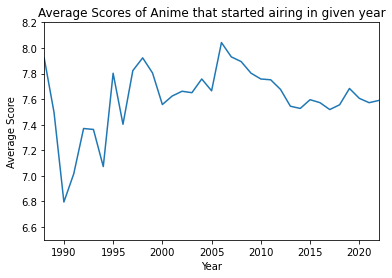

In [373]:
plt.plot(years,animeyearavgs)
plt.axis([1988, 2022, 6.5, 8.2])

plt.xlabel('Year')
plt.ylabel('Average Score')
plt.title('Average Scores of Anime that started airing in given year')
plt.show()

In [259]:
#let's look at how users who have completed an anime rate that anime as a function of the percentage of drops
#we have the scores of a particular anime by people who have completed it.
#now let's look at the number of people who have dropped a particular anime

#drops per anime
dropsPerAnime = defaultdict(int)
for i in readCSV('../data/user_animelist_details.txt'):
    #we checked to see if it has been dropped
    if(i[6] == 3):
        #increment the drop counter
        dropsPerAnime[i[1]]+=1

In [262]:
len(dropsPerAnime)

9117

In [390]:
#let's put these in bins to graph and then average
#each bin represents 1 percent drop rate
drop_rate_bins = [[] for j in range(100)]
for animeid in scoresPerAnime:
    if (animeid in dropsPerAnime):
        if math.floor((100*dropsPerAnime[animeid]/len(scoresPerAnime[animeid]))) > 99:
            drop_rate_bins[99] += scoresPerAnime[animeid]
            continue
        drop_rate_bins[math.floor((100*dropsPerAnime[animeid]/len(scoresPerAnime[animeid])))] += scoresPerAnime[animeid]
drop_rate_avgs = [sum(i)/len(i) for i in drop_rate_bins]

In [393]:
len(drop_rate_avgs)

100

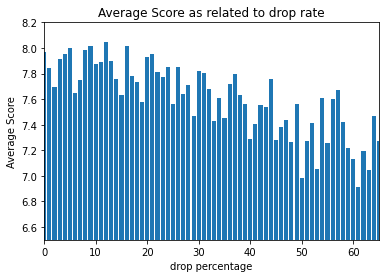

In [397]:
plt.bar(range(100),drop_rate_avgs)
plt.axis([0, 65, 6.5, 8.2])

plt.xlabel('drop percentage')
plt.ylabel('Average Score')
plt.title('Average Score as related to drop rate')
plt.show()

In [11]:
#let's look at how users who have completed an anime rate that anime as a function of the percentage of drops
#we have the scores of a particular anime by people who have completed it.
#now let's look at the number of people who have dropped a particular anime

#drops per anime
plansPerAnime = defaultdict(int)
for i in readCSV('../data/user_animelist_details.txt'):
    #we checked to see if it has been dropped
    if(i[6] == 4):
        #increment the drop counter
        plansPerAnime[i[1]]+=1

In [45]:
len(scoresPerAnime[49877])

1

In [44]:
plansPerAnime[49877]

301

In [47]:
#let's put these in bins to graph and then average
#each bin represents 1 percent plan rate
plan_rate_bins = [[] for j in range(40000)]
for animeid in scoresPerAnime:
    if (animeid in plansPerAnime):
        print(animeid)
        print(100*plansPerAnime[animeid]/len(scoresPerAnime[animeid]))
        plan_rate_bins[math.floor((100*plansPerAnime[animeid]/len(scoresPerAnime[animeid])))] += scoresPerAnime[animeid]
plan_rate_avgs = [sum(i)/len(i) if len(i) != 0 else  0 for i in plan_rate_bins ]

1004
87.65432098765432
433
231.99404761904762
101
145.43034605146406
4744
82.71918678526048
5081
89.29336188436831
1222
215.97222222222223
1575
64.51109028428615
2904
46.40746500777605
2025
134.71894189891356
2924
155.4959785522788
72
97.81477627471384
2508
102.90322580645162
3299
149.20318725099602
3652
135.00533617929563
21327
72.86295793758481
3958
107.85241248817408
2581
97.14611872146119
3927
65.6019656019656
147
209.9290780141844
1887
104.1958041958042
330
135.05747126436782
2931
726.1904761904761
1210
147.90494058786743
1569
243.91143911439116
853
72.6607422895975
65
109.66010733452593
2476
107.56676557863501
24
188.86389201349832
846
106.66666666666667
2104
201.6184971098266
2787
106.18120237087214
1965
220.625
3470
122.3076923076923
849
96.54255319148936
2001
89.40058479532163
4224
61.2565445026178
856
258.52156057494864
3712
57.302474062250596
38101
70.89337175792507
552
43.30900243309002
2961
58.38509316770186
2397
88.39285714285714
34933
65.68877551020408
37086
85.459183673

6882
95.93023255813954
1030
159.0909090909091
8768
119.93127147766323
4811
86.17021276595744
1888
94.88636363636364
9938
109.60698689956332
10804
81.0126582278481
228
261.7647058823529
141
303.84615384615387
4814
61.69064748201439
3805
255.8139534883721
5978
71.52542372881356
3935
900.0
1637
204.54545454545453
1579
200.85470085470087
3392
115.0326797385621
5717
115.23809523809524
8129
101.58061116965227
3358
172.6775956284153
416
122.95918367346938
6793
95.95375722543352
4903
199.51456310679612
6379
376.9230769230769
2911
588.8888888888889
10893
151.1811023622047
1013
519.108280254777
1430
86.36363636363636
5713
137.39837398373984
2751
432.43243243243245
2235
111.53846153846153
2246
367.741935483871
3001
149.3362831858407
3618
119.11764705882354
1174
426.6666666666667
1135
311.1111111111111
1209
153.48837209302326
8857
74.47447447447448
10197
56.13382899628253
1029
245.63106796116506
2159
196.5034965034965
3887
48.421052631578945
683
214.28571428571428
6896
108.47457627118644
4130
253.

314.2857142857143
40956
78.37837837837837
36245
180.7017543859649
39063
245.87155963302752
39811
190.69767441860466
34321
59.765625
25537
326.6666666666667
33049
245.06172839506172
36317
119.46902654867256
36144
211.11111111111111
19889
309.09090909090907
16918
80.28335301062573
19363
36.434108527131784
39576
278.51851851851853
27631
115.32567049808429
43692
76.5625
37989
63.63636363636363
40059
94.32624113475177
23279
650.0
36094
175.2941176470588
43591
178.2608695652174
28607
95.89041095890411
39468
91.56118143459915
5998
347.9166666666667
40046
142.7860696517413
38790
71.03658536585365
31405
93.45549738219896
33129
394.44444444444446
38619
193.82716049382717
16904
301.0869565217391
27991
112.30366492146597
30524
101.11111111111111
32682
73.4375
9159
231.42857142857142
37981
422.22222222222223
1192
126.86567164179104
40221
59.583333333333336
39198
152.58215962441315
40196
246.875
39199
160.71428571428572
39326
149.62962962962962
37965
174.30167597765364
24439
120.17220172201722
40908

124.67532467532467
2201
132.0
1020
410.0
1037
584.0
1043
314.11764705882354
7739
76.0
9925
62.33766233766234
12505
70.66666666666667
9598
123.52941176470588
10477
104.41176470588235
10604
91.38755980861244
12461
182.70676691729324
5231
240.2439024390244
16317
33.6283185840708
9750
133.81294964028777
10934
142.3913043478261
7598
231.30434782608697
8792
52.0
7135
391.52542372881356
14527
64.54183266932272
9510
58.18181818181818
1688
339.1304347826087
24705
96.73913043478261
14093
96.96969696969697
17873
66.66666666666667
20743
153.84615384615384
17115
70.0
4026
117.0
6178
137.2093023255814
7695
138.46153846153845
1709
89.01098901098901
10933
100.97087378640776
941
372.54901960784315
1489
145.0
1731
205.5194805194805
5306
197.39583333333334
6169
637.0370370370371
31430
65.29411764705883
21353
87.47152619589977
10033
263.57615894039736
41587
87.33624454148472
41491
162.59541984732823
4672
302.8708133971292
4657
275.75757575757575
34443
113.20754716981132
39555
94.44444444444444
40935
109.1

1374
312.72727272727275
876
147.14285714285714
9982
66.44736842105263
22673
193.47826086956522
1254
336.5853658536585
1257
116.48351648351648
40507
151.31578947368422
373
442.3076923076923
40960
120.33898305084746
13807
125.0
15037
116.49214659685863
43814
95.89041095890411
779
60.50420168067227
780
63.06306306306306
14735
107.14285714285714
21419
83.60655737704919
32005
97.77777777777777
34430
89.47368421052632
35798
96.96969696969697
563
231.31313131313132
1187
196.0
39026
107.14285714285714
40064
70.17543859649123
41710
70.35175879396985
49930
62.0
32936
147.87234042553192
35757
156.8181818181818
37154
243.33333333333334
18713
52.94117647058823
12729
98.22485207100591
22835
70.08196721311475
49297
140.0
44524
79.5275590551181
16101
326.6666666666667
28387
110.88709677419355
40750
77.40585774058577
40716
143.26923076923077
41312
74.35897435897436
24451
77.96610169491525
30915
81.48148148148148
40595
126.08695652173913
51213
124.13793103448276
40974
80.0
49776
101.16279069767442
51064

10463
350.0
3597
333.3333333333333
1800
350.0
504
290.90909090909093
36914
323.52941176470586
36915
129.62962962962962
38085
592.8571428571429
38086
572.0
41497
656.5217391304348
36166
88.88888888888889
10666
65.0
2042
292.3076923076923
6557
240.0
7902
206.8181818181818
37657
425.0
33392
76.47058823529412
33911
150.0
1927
170.0
32071
67.66917293233082
28539
348.2758620689655
43350
100.0
37140
500.0
2196
185.0
43741
90.0
33025
206.25
2474
330.0
19261
156.52173913043478
10643
338.29787234042556
40323
557.1428571428571
39486
247.91666666666666
32366
167.94871794871796
6413
220.0
36816
130.6122448979592
37897
80.85106382978724
3190
400.0
5501
545.4545454545455
37247
48.148148148148145
27907
200.0
35982
178.94736842105263
3288
528.5714285714286
8839
1150.0
39674
175.0
31454
550.0
4540
196.0
498
537.5
35237
190.32258064516128
1465
236.0
36029
630.0
38650
133.33333333333334
42940
48.214285714285715
20903
134.7826086956522
48413
404.23728813559325
38733
29.26829268292683
28439
80.0
1371
480.76

706
468.75
707
311.7647058823529
2312
288.8888888888889
2473
337.5
515
309.09090909090907
1206
344.82758620689657
1150
393.75
1148
304.1666666666667
1006
346.15384615384613
1144
425.0
1651
470.5882352941176
1018
704.1666666666666
1267
675.0
19257
202.22222222222223
30382
194.87179487179486
17391
66.17647058823529
15195
111.53846153846153
4052
282.60869565217394
1182
477.14285714285717
16319
80.0
15795
366.6666666666667
32906
60.869565217391305
25439
66.66666666666667
932
110.0
3100
400.0
34888
100.0
17351
89.47368421052632
12503
266.6666666666667
5322
344.44444444444446
16468
118.18181818181819
163
515.3846153846154
16395
88.60759493670886
8171
292.6829268292683
38400
7400.0
9723
252.38095238095238
33248
1810.0
37303
431.25
42091
575.8620689655172
12121
76.47058823529412
9353
452.94117647058823
1872
750.0
11307
400.0
5526
64.40677966101696
48842
149.18032786885246
37975
157.5
47162
148.4375
9203
153.65853658536585
3381
800.0
1252
576.9230769230769
43609
196.1038961038961
2717
1450.0
64

316.6666666666667
1644
192.30769230769232
34903
461.53846153846155
2096
233.33333333333334
44196
225.0
38918
250.0
4948
400.0
33969
1350.0
3332
1900.0
12715
440.0
40735
333.3333333333333
44068
100.0
2103
311.1111111111111
38917
292.85714285714283
9344
200.0
2715
250.0
36654
169.23076923076923
22583
654.5454545454545
6276
177.77777777777777
3905
400.0
13843
945.4545454545455
40208
233.33333333333334
39024
33.333333333333336
33758
120.0
38467
100.0
38491
40.0
49386
33.333333333333336
38741
100.0
41916
350.0
4943
775.0
7818
300.0
42284
66.66666666666667
44071
100.0
37185
33.333333333333336
33350
1071.4285714285713
7568
778.125
8064
916.6666666666666
1757
135.71428571428572
1752
310.0
1597
666.6666666666666
1247
687.5
1753
287.5
216
442.85714285714283
30743
100.0
3490
375.0
2487
200.0
4617
375.0
749
480.0
4314
300.0
4316
333.3333333333333
2234
875.0
835
789.4736842105264
2727
323.0769230769231
45753
110.34482758620689
35720
400.0
35965
200.0
39735
100.0
49292
416.6666666666667
39728
157.14

509.09090909090907
2648
400.0
2790
325.0
30829
211.11111111111111
21853
355.55555555555554
36729
820.0
1711
925.0
35353
50.0
40849
200.0
2364
441.6666666666667
15325
221.42857142857142
31231
119.23076923076923
13837
205.26315789473685
48470
312.5
34776
600.0
42657
100.0
41834
494.11764705882354
42946
33.333333333333336
40085
357.14285714285717
40136
188.23529411764707
40506
325.0
48680
500.0
37318
350.0
37509
580.0
46118
227.27272727272728
660
1083.3333333333333
38409
307.6923076923077
2252
1300.0
2813
260.0
3006
700.0
8704
150.0
17659
162.5
2941
800.0
51306
291.6666666666667
43568
22.22222222222222
41659
633.3333333333334
39592
400.0
49730
28.571428571428573
24591
62.5
3462
500.0
34052
500.0
28339
66.66666666666667
44040
25.0
40137
500.0
31014
100.0
5469
520.0
33541
70.0
20189
150.0
6383
400.0
33859
100.0
32932
1100.0
10375
200.0
19209
150.0
9880
100.0
13287
200.0
5688
3000.0
3579
3050.0
15993
133.33333333333334
31505
200.0
5250
2100.0
42984
76.92307692307692
5658
1200.0
22099
200.0
2

38719
433.3333333333333
36342
1000.0
36343
1850.0
51149
100.0
35975
50.0
9496
400.0
38777
1000.0
38739
1000.0
23943
650.0
32927
300.0
36436
1150.0
40181
100.0
37668
100.0
50840
166.66666666666666
51424
200.0
51150
50.0
18391
700.0
49370
300.0
40031
933.3333333333334
40971
500.0
34165
100.0
36683
666.6666666666666
36796
362.5
39864
900.0
51015
50.0
42174
1500.0
23849
1250.0
42161
180.0
32219
100.0
42380
200.0
40630
200.0
36240
137.5
40348
100.0
31133
166.66666666666666
36239
271.42857142857144
42893
675.0
33898
250.0
39014
3700.0
42737
50.0
33185
6100.0
36556
1800.0
35645
1140.0
1712
1200.0
28647
133.33333333333334
29933
100.0
26111
50.0
12863
562.5
25857
266.6666666666667
29123
100.0
38804
150.0
40880
66.66666666666667
31309
100.0
6849
100.0
12803
500.0
31761
100.0
41206
325.0
36529
2000.0
49733
1425.0
9548
300.0
3460
1000.0
42106
750.0
970
5100.0
42913
200.0
10723
3300.0
10534
275.0
51225
300.0
40134
600.0
10346
1100.0
10370
820.0
42143
69.23076923076923
32412
625.0
23115
2000.0
36223

400.0
48455
300.0
33618
1300.0
40464
1800.0
29697
600.0
49345
3800.0
2786
4000.0
18447
200.0
25495
200.0
30155
100.0
27539
100.0
3295
5700.0
31880
100.0
33905
300.0
12561
700.0
39962
200.0
7498
300.0
36622
100.0
29551
200.0
5878
1000.0
7497
500.0
38412
200.0
30045
200.0
7494
500.0
42012
100.0
40147
200.0
38051
200.0
37406
200.0
41360
300.0
35301
400.0
42486
200.0
38019
700.0
8216
1100.0
13029
2600.0
10105
1400.0
19121
200.0
5647
1000.0
30193
200.0
5476
1100.0
2572
1800.0
5131
500.0
18273
200.0
9095
300.0
5207
600.0
5927
300.0
4808
1500.0
19053
200.0
6366
400.0
5928
1000.0
20505
800.0
3064
1200.0
7461
600.0
2737
800.0
20713
100.0
3881
1200.0
1975
700.0
4933
600.0
1740
2300.0
8842
400.0
7876
800.0
34346
400.0
16247
400.0
3252
600.0
25591
500.0
2718
1200.0
8928
1000.0
32751
100.0
29087
1400.0
39298
1400.0
9944
2800.0
50515
100.0
39831
100.0
2654
600.0
11053
1100.0
19645
600.0
31201
300.0
2650
600.0
8140
300.0
8139
400.0
34178
450.0
35156
100.0
17387
300.0
36095
100.0
7496
1900.0
22055
200

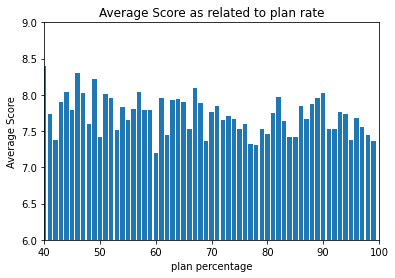

In [53]:
plt.bar(range(500),plan_rate_avgs[:500])
plt.axis([40, 500, 6, 9])

plt.xlabel('plan percentage')
plt.ylabel('Average Score')
plt.title('Average Score as related to plan rate')
plt.show()

In [283]:
#let's try binning by day of week review was made on
ratingsPerWeekday = defaultdict(list)
for i in completed_with_date:
    #some date data is in a different format, can tell by length
    if(len(i[3]) == 10):
        tempDate = datetime.strptime(i[3],'%Y-%m-%d')
    elif (len(i[3]) == 4):
        #day is not included, let's skip
        continue
        tempDate = datetime.strptime(i[3],'%Y')
    elif (len(i[3]) == 7):
        #day is not included, let's skip
        continue
    else:
        #we don't know the date so we toss it
        continue
    ratingsPerWeekday[tempDate.strftime('%A')].append(i[4])

In [289]:
days = []
scoresPerDay = []

scoresPerDay.append(sum(ratingsPerWeekday['Sunday'])/len(ratingsPerWeekday['Sunday']))
days.append('Sunday')

scoresPerDay.append(sum(ratingsPerWeekday['Monday'])/len(ratingsPerWeekday['Monday']))
days.append('Monday')

scoresPerDay.append(sum(ratingsPerWeekday['Tuesday'])/len(ratingsPerWeekday['Tuesday']))
days.append('Tuesday')

scoresPerDay.append(sum(ratingsPerWeekday['Wednesday'])/len(ratingsPerWeekday['Wednesday']))
days.append('Wednesday')

scoresPerDay.append(sum(ratingsPerWeekday['Thursday'])/len(ratingsPerWeekday['Thursday']))
days.append('Thursday')

scoresPerDay.append(sum(ratingsPerWeekday['Friday'])/len(ratingsPerWeekday['Friday']))
days.append('Friday')

scoresPerDay.append(sum(ratingsPerWeekday['Saturday'])/len(ratingsPerWeekday['Saturday']))
days.append('Saturday')
    

In [293]:
scoresPerDay

[7.711491547185962,
 7.690966558487371,
 7.686278511701548,
 7.681915929819235,
 7.690734447690822,
 7.670241501307491,
 7.68357332074383]

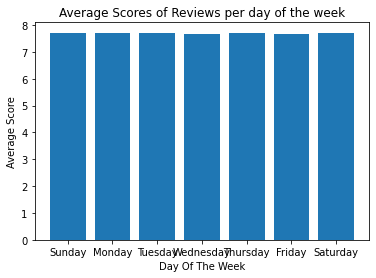

In [292]:
plt.bar(days,scoresPerDay)

plt.xlabel('Day Of The Week')
plt.ylabel('Average Score')
plt.title('Average Scores of Reviews per day of the week')
plt.show()

In [359]:
#let's try binning by day of week anime was broadcast on
ratingsPerWeekday = defaultdict(list)
for record in completed_with_date:
    animeid = record[1]
    if(animeid in animelistdict2):
        animeDetails = animelistdict2[animeid]
        ratingsPerWeekday[animeDetails['broadcast']['day_of_the_week']].append(record[4])
    else:
        continue

In [365]:
scoresPerDay = []

scoresPerDay.append(sum(ratingsPerWeekday['sunday'])/len(ratingsPerWeekday['sunday']))

scoresPerDay.append(sum(ratingsPerWeekday['monday'])/len(ratingsPerWeekday['monday']))

scoresPerDay.append(sum(ratingsPerWeekday['tuesday'])/len(ratingsPerWeekday['tuesday']))

scoresPerDay.append(sum(ratingsPerWeekday['wednesday'])/len(ratingsPerWeekday['wednesday']))

scoresPerDay.append(sum(ratingsPerWeekday['thursday'])/len(ratingsPerWeekday['thursday']))

scoresPerDay.append(sum(ratingsPerWeekday['friday'])/len(ratingsPerWeekday['friday']))

scoresPerDay.append(sum(ratingsPerWeekday['saturday'])/len(ratingsPerWeekday['saturday']))
    

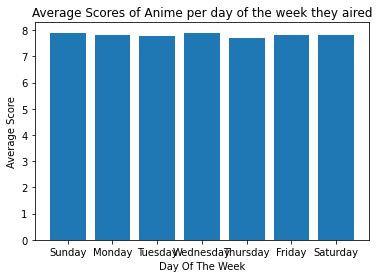

In [366]:
plt.bar(days,scoresPerDay)

plt.xlabel('Day Of The Week')
plt.ylabel('Average Score')
plt.title('Average Scores of Anime per day of the week they aired')
plt.show()

In [369]:
animelist[0]

{'id': 41467,
 'title': 'Bleach: Sennen Kessen-hen',
 'main_picture': {'medium': 'https://api-cdn.myanimelist.net/images/anime/1764/126627.jpg',
  'large': 'https://api-cdn.myanimelist.net/images/anime/1764/126627l.jpg'},
 'start_date': '2022-10-11',
 'mean': 9.12,
 'rank': 1,
 'popularity': 707,
 'num_list_users': 294302,
 'num_scoring_users': 76007,
 'synopsis': "Substitute Soul Reaper Ichigo Kurosaki spends his days fighting against Hollows, dangerous evil spirits that threaten Karakura Town. Ichigo carries out his quest with his closest allies: Orihime Inoue, his childhood friend with a talent for healing; Yasutora Sado, his high school classmate with superhuman strength; and Uryuu Ishida, Ichigo's Quincy rival.\n\nIchigo's vigilante routine is disrupted by the sudden appearance of Asguiaro Ebern, a dangerous Arrancar who heralds the return of Yhwach, an ancient Quincy king. Yhwach seeks to reignite the historic blood feud between Soul Reaper and Quincy, and he sets his sights on e

In [ ]:
# some more ideas on things to test
# numbers of planned to watch, sequential factors such as sequels (i would need to gather data on this, but it is very possible, genres, airing season, number of drops a user has indicating their mean score)

In [404]:
ratingsPerSeason = defaultdict(list)
for record in completed_with_date:
    animeid = record[1]
    if(animeid in animelistdict2):
        animeDetails = animelistdict3[animeid]
        ratingsPerSeason[animeDetails['start_season']['season']].append(record[4])
    else:
        continue

In [406]:
for key in ratingsPerSeason:
    print(key)

winter
summer
fall
spring


In [408]:
seasons = []
scoresSeason = []

scoresSeason.append(sum(ratingsPerSeason['winter'])/len(ratingsPerSeason['winter']))
seasons.append('winter')

scoresSeason.append(sum(ratingsPerSeason['summer'])/len(ratingsPerSeason['summer']))
seasons.append('summer')

scoresSeason.append(sum(ratingsPerSeason['fall'])/len(ratingsPerSeason['fall']))
seasons.append('fall')

scoresSeason.append(sum(ratingsPerSeason['spring'])/len(ratingsPerSeason['spring']))
seasons.append('spring')

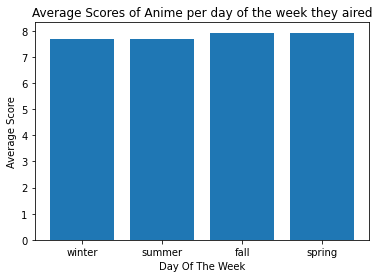

In [409]:
plt.bar(seasons,scoresSeason)

plt.xlabel('Day Of The Week')
plt.ylabel('Average Score')
plt.title('Average Scores of Anime per day of the week they aired')
plt.show()